<a href="https://colab.research.google.com/github/ankit-rathi/Data-Science-with-Python/blob/master/Tradevesting/myProspects_200-50-20-DMA_Signals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import datetime
import pytz
tz_NY = pytz.timezone('Asia/Kolkata')
datetime_NY = datetime.datetime.now(tz_NY)
print("Run date time (IST):", datetime_NY.strftime("%Y-%m-%d %H:%M:%S"))

Run date time (IST): 2023-06-29 11:19:10


In [ ]:
!pip install yfinance
!pip install pandas-ta
#!pip install talib-binary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218908 sha256=2a3370ed50784ac66346586ce3c8b458e328800a26c90912eb2b9cb1e2b03bdb
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas-ta


In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

mypf = pd.read_csv('/content/drive/My Drive/data/stocks/myProspectsScrips.csv')

mypf = mypf[(mypf['Criteria'] == 'V40') | (mypf['Criteria'] == 'V40N')]

stock_n100 = mypf['Symbol'].unique()

exclude = ['CADILAHC','MMTC']

stock_n100 = mypf[~mypf['Symbol'].isin(exclude) ]['Symbol'].unique()

stock_ids = stock_n100

#mypf = mypf[mypf.Forecast.notnull()]
#stock_ids = mypf['Symbol'].unique()

stock_ids.sort()
#stock_ids

Mounted at /content/drive


In [ ]:
# import necessary libraries

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')
import pandas_datareader.data as web
import yfinance as yfin
#import talib
yfin.pdr_override()
import pandas_ta as ta

In [ ]:
# function to compute stock attributes

def stock_prec_dev(stock_symbol, date):
    #stock_symbol = 'ULTRACEMCO.NS'
    short_window = 20
    mid_window = 50
    long_window = 200
    moving_avg = 'SMA'

    end_date = date.strftime('%Y-%m-%d')
    start_date = (date + datetime.timedelta(days=-365*3)).strftime('%Y-%m-%d')
    # import the closing price data of the stock for the aforementioned period of time in Pandas dataframe
    #start = datetime.datetime(*map(int, start_date.split('-')))
    #end = datetime.datetime(*map(int, end_date.split('-')))
    stock_df = yfin.Ticker(stock_symbol).history(period='3y')[map(str.title, ['open', 'close', 'low', 'high', 'volume'])]
    stock_df = stock_df[(stock_df.index <= end_date) & (stock_df.index >= start_date)]
    #stock_df = pd.DataFrame(stock_df) # convert Series object to dataframe
    #stock_df.columns = {'Close Price'} # assign new colun name
    stock_df.dropna(axis = 0, inplace = True) # remove any null rows

    # column names for long and short moving average columns
    short_window_col = str(short_window) + '_' + moving_avg
    mid_window_col = str(mid_window) + '_' + moving_avg
    long_window_col = str(long_window) + '_' + moving_avg

    #print(stock_df)

    # Create short exponential moving average column
    stock_df[short_window_col] = round(stock_df['Close'].rolling(window = short_window, min_periods = 1).mean(),0)

    stock_df[mid_window_col] = round(stock_df['Close'].rolling(window = mid_window, min_periods = 1).mean(),0)

    #stock_df['RSI'] = round(talib.RSI(stock_df['Close Price'], timeperiod=14),0)

    # Create a long exponential moving average column
    stock_df[long_window_col] = round(stock_df['Close'].rolling(window = long_window, min_periods = 1).mean(),0)
    stock_df['Stock'] = stock_symbol
    stock_df['Dev%_200'] = round((stock_df['Close'] - stock_df['200_SMA'])*100/stock_df['200_SMA'],2)
    stock_df['Close'] = round(stock_df['Close'],0)
    stock_df.drop(['Open', 'Low', 'High', 'Volume'
                   ], axis=1, inplace=True)

    return stock_df

def get_stock_buy_sell(stock_symbol):
    date = (datetime.date.today() + datetime.timedelta(days=0))
    df_prec_dev = stock_prec_dev(stock_symbol, date)
    df_prec_dev['Signal'] = 0.0
    df_prec_dev['Signal'] = np.where(((df_prec_dev['Close'] < df_prec_dev['20_SMA']) & (df_prec_dev['20_SMA'] < df_prec_dev['50_SMA']) & (df_prec_dev['50_SMA'] < df_prec_dev['200_SMA'])), 1.0, df_prec_dev['Signal'])

    df_prec_dev['Signal'] = np.where(((df_prec_dev['Close'] > df_prec_dev['20_SMA']) & (df_prec_dev['20_SMA'] > df_prec_dev['50_SMA']) & (df_prec_dev['50_SMA'] > df_prec_dev['200_SMA'])), -1.0, df_prec_dev['Signal'])

    df_prec_dev['Position'] = df_prec_dev['Signal'].diff()

    df_pos = df_prec_dev[(df_prec_dev['Position'] >= 1) | (df_prec_dev['Position'] <= -1)]
    df_pos = df_pos[df_pos['Signal'] != 0]
    df_pos['Prev_Signal'] = df_pos['Signal'].shift(1)
    df_pos = df_pos[df_pos['Signal'] != df_pos['Prev_Signal']]
    df_pos.drop('Prev_Signal', axis=1, inplace=True)

    return df_pos.tail(1)

def get_daily_buy_sell():
    df_buy_sell = pd.DataFrame()
    for stock_id in stock_ids:
        df_tmp = get_stock_buy_sell(stock_id+'.NS')
        df_tmp['Criteria'] = mypf[(mypf['Symbol']) == stock_id.upper()]['Criteria'].values[0]
        df_buy_sell = df_buy_sell.append(df_tmp)


    df_buy_sell['Position'] = df_buy_sell['Position'].apply(lambda x: 'Buy' if x >= 1 else 'Sell')
    return df_buy_sell.sort_index()

def plot_stock_buy_sell(stock_symbol):
    date = (datetime.date.today() + datetime.timedelta(days=0))
    df_prec_dev = stock_prec_dev(stock_symbol, date)
    df_prec_dev['Signal'] = 0.0
    df_prec_dev['Signal'] = np.where(((df_prec_dev['Close'] < df_prec_dev['20_SMA']) & (df_prec_dev['20_SMA'] < df_prec_dev['50_SMA']) & (df_prec_dev['50_SMA'] < df_prec_dev['200_SMA'])), 1.0, df_prec_dev['Signal'])

    df_prec_dev['Signal'] = np.where(((df_prec_dev['Close'] > df_prec_dev['20_SMA']) & (df_prec_dev['20_SMA'] > df_prec_dev['50_SMA']) & (df_prec_dev['50_SMA'] > df_prec_dev['200_SMA'])), -1.0, df_prec_dev['Signal'])

    df_prec_dev['Position'] = df_prec_dev['Signal'].diff()

    # plot close price, short-term and long-term moving averages
    plt.figure(figsize = (20,10))
    plt.tick_params(axis = 'both', labelsize = 14)
    df_prec_dev['Close'].plot(color = 'k', lw = 1, label = 'Close')
    #stock_df[short_window_col].plot(color = 'g', lw = 1, label = short_window_col)
    df_prec_dev['20_SMA'].plot(color = 'g', lw = 1, label = '20_SMA')
    df_prec_dev['50_SMA'].plot(color = 'm', lw = 1, label = '50_SMA')
    df_prec_dev['200_SMA'].plot(color = 'b', lw = 1, label = '200_SMA')

    df_pos = df_prec_dev[(df_prec_dev['Position'] >= 1) | (df_prec_dev['Position'] <= -1)]
    df_pos = df_pos[df_pos['Signal'] != 0]
    df_pos['Prev_Signal'] = df_pos['Signal'].shift(1)
    df_pos = df_pos[df_pos['Signal'] != df_pos['Prev_Signal']]
    df_pos.drop('Prev_Signal', axis=1, inplace=True)


    # plot 'buy' signals
    plt.plot(df_pos[df_pos['Position'] >= 1].index,
          df_pos['Close'][df_pos['Position'] >= 1],
          '^', markersize = 15, color = 'g', alpha = 0.7, label = 'buy')

    # plot 'sell' signals
    plt.plot(df_pos[df_pos['Position'] <= -1].index,
          df_pos['Close'][df_pos['Position'] <= -1],
          'v', markersize = 15, color = 'r', alpha = 0.7, label = 'sell')

    plt.ylabel('Price in ₹', fontsize = 16 )
    plt.xlabel('Date', fontsize = 16 )
    plt.title(stock_symbol + '  : Buy/Sell Signal', fontsize = 20)
    plt.legend()
    plt.grid()
    plt.show()

    display_table = True

    if display_table == True:
      print(stock_symbol)
      df_pos['Position'] = df_pos['Position'].apply(lambda x: 'Buy' if x >= 1 else 'Sell')
      print(tabulate(df_pos, headers = 'keys', tablefmt = 'psql'))

df_daily_buy_sell = get_daily_buy_sell()

In [ ]:
df_daily_buy_sell[df_daily_buy_sell['Position'] == 'Sell'].tail(20)

,Close,20_SMA,50_SMA,200_SMA,Stock,Dev%_200,Signal,Position,Criteria
Date,,,,,,,,,
2023-06-06 00:00:00+05:30,543.0,538.0,507.0,506.0,MARICO.NS,7.26,-1.0,Sell,V40
2023-06-08 00:00:00+05:30,3657.0,3652.0,3365.0,3362.0,EICHERMOT.NS,8.79,-1.0,Sell,V40N
2023-06-12 00:00:00+05:30,373.0,344.0,317.0,315.0,5PAISA.NS,18.40,-1.0,Sell,V40N
2023-06-12 00:00:00+05:30,582.0,573.0,546.0,544.0,HDFCLIFE.NS,7.07,-1.0,Sell,V40
2023-06-14 00:00:00+05:30,3652.0,3387.0,3289.0,3287.0,ASTRAZEN.NS,11.12,-1.0,Sell,V40N
2023-06-19 00:00:00+05:30,814.0,773.0,711.0,709.0,CAPLIPOINT.NS,14.85,-1.0,Sell,V40N
2023-06-19 00:00:00+05:30,3310.0,3192.0,3035.0,3033.0,ASIANPAINT.NS,9.12,-1.0,Sell,V40
2023-06-20 00:00:00+05:30,7218.0,7027.0,6583.0,6562.0,BAJFINANCE.NS,9.99,-1.0,Sell,V40
2023-06-20 00:00:00+05:30,7710.0,7562.0,6991.0,6960.0,TATAELXSI.NS,10.78,-1.0,Sell,V40N


In [ ]:
df_daily_buy_sell[df_daily_buy_sell['Position'] == 'Buy'].tail(20)

,Close,20_SMA,50_SMA,200_SMA,Stock,Dev%_200,Signal,Position,Criteria
Date,,,,,,,,,
2022-11-11 00:00:00+05:30,1531.0,1564.0,1650.0,1653.0,WHIRLPOOL.NS,-7.41,1.0,Buy,V40
2022-11-15 00:00:00+05:30,4567.0,4572.0,4734.0,4781.0,BAYERCROP.NS,-4.47,1.0,Buy,V40N
2022-11-22 00:00:00+05:30,1680.0,1771.0,1810.0,1811.0,BATAINDIA.NS,-7.22,1.0,Buy,V40
2022-12-28 00:00:00+05:30,1969.0,2027.0,2032.0,2051.0,VINATIORGA.NS,-4.02,1.0,Buy,V40N
2023-01-02 00:00:00+05:30,799.0,825.0,870.0,873.0,TTKPRESTIG.NS,-8.51,1.0,Buy,V40N
2023-01-04 00:00:00+05:30,650.0,659.0,680.0,682.0,ERIS.NS,-4.67,1.0,Buy,V40N
2023-01-06 00:00:00+05:30,4961.0,4977.0,5040.0,5049.0,GILLETTE.NS,-1.74,1.0,Buy,V40
2023-01-09 00:00:00+05:30,41270.0,43165.0,45715.0,45729.0,PAGEIND.NS,-9.75,1.0,Buy,V40
2023-01-17 00:00:00+05:30,2138.0,2248.0,2347.0,2351.0,LALPATHLAB.NS,-9.07,1.0,Buy,V40N


In [ ]:
tmp_df = df_daily_buy_sell.reset_index()
tmp_df.to_csv('/content/drive/My Drive/data/stocks/myProspects-Buy-Sell-Signals.csv', index=False)

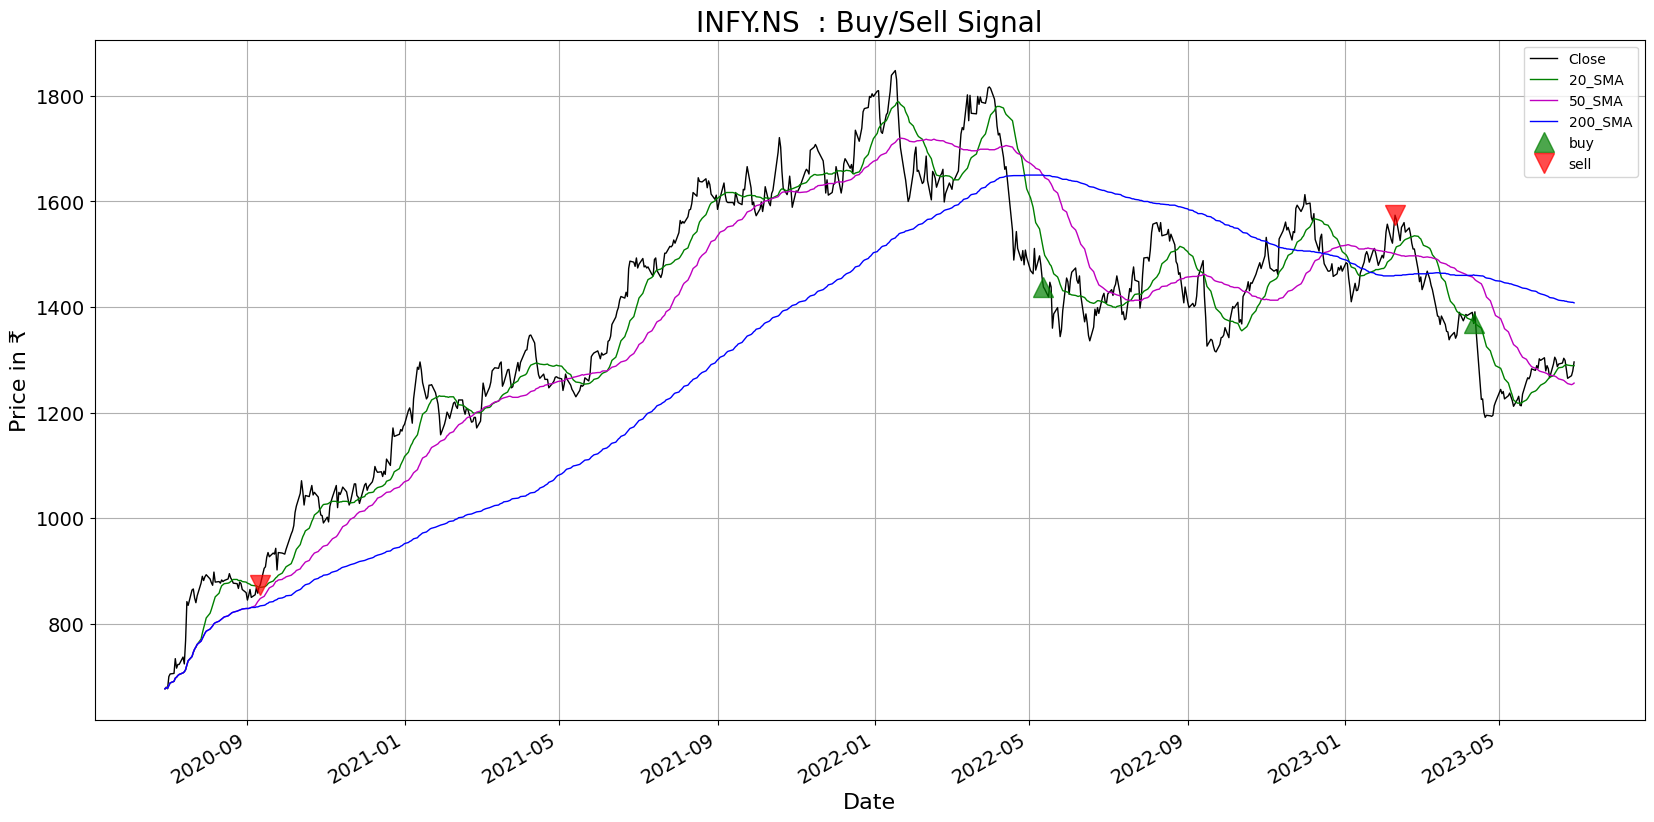

INFY.NS
+---------------------------+---------+----------+----------+-----------+---------+------------+----------+------------+
| Date                      |   Close |   20_SMA |   50_SMA |   200_SMA | Stock   |   Dev%_200 |   Signal | Position   |
|---------------------------+---------+----------+----------+-----------+---------+------------+----------+------------|
| 2020-09-11 00:00:00+05:30 |     874 |      869 |      848 |       834 | INFY.NS |       4.85 |       -1 | Sell       |
| 2022-05-12 00:00:00+05:30 |    1438 |     1509 |     1649 |      1650 | INFY.NS |     -12.85 |        1 | Buy        |
| 2023-02-09 00:00:00+05:30 |    1574 |     1508 |     1501 |      1460 | INFY.NS |       7.83 |       -1 | Sell       |
| 2023-04-11 00:00:00+05:30 |    1369 |     1372 |     1455 |      1461 | INFY.NS |      -6.29 |        1 | Buy        |
+---------------------------+---------+----------+----------+-----------+---------+------------+----------+------------+


In [ ]:
stock_symbol = 'INFY.NS'
plot_stock_buy_sell(stock_symbol)